In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from functions import *

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.optimize import minimize
from multiprocess import Pool

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#Set params
n = 1000

#Data generation 
X = np.random.uniform(-2,2,n)
X.sort()

eps = np.random.normal(0, 1,  n)

In [3]:
a = 0.5

#Missing values 

b0 = 0.8
b1 =  0.8

y = fan(X,n,a,eps)

In [4]:
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

df = pd.DataFrame({'x':X,'y':y,'omega':omega})

#ipw

df['y_pi'] =  df['y'].apply(lambda t: t/pi(t,b0,b1))

df['var'] = df['x'].apply(lambda t: sigma_reg(t,len(df)))

df_cc = df.loc[df['omega']==1].reset_index(drop=True)

In [5]:
size = round(len(df_cc)*100/len(df))
size

69

In [6]:
#Model calibration

model = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')


In [7]:
def r_parallel_cc(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return df.omega[j]*(df.y[j]-y_hat)**2 #/pi(df.y[j],b0,b1)

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [8]:
h_ipw_cc = minimize(r_parallel_cc, 0.1).x

In [9]:
df['res'] = (df['y'] - model.fit(df['x'])[0])**2
df_cc['res'] = (df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw_cc,t,X,y,pi(y,b0,b1),omega)))**2

In [10]:
model_res = KernelReg(endog=[df.res],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')


In [11]:
df_cc[['x']].shape

(686, 1)

In [12]:
def nw_mis(h,x,X,y,p,omega):
    #if h < 0.001:
    #    h = 0.001
    y = ((y*omega)/p)
    num = sum(y*norm.pdf((x-X)/h))
    dem = sum((omega/p)*norm.pdf((x-X)/h))
    return num/dem

In [13]:
# Create a DataFrame using the array
df_ones = pd.DataFrame(np.ones(df_cc[['x']].shape))

def r_parallel_res(h):
    #print(1)
    def fn(j):
        df1 = df_cc.drop([j],axis=0)
        df_ones1 = df_ones.drop([j],axis=0)
        y_hat = nw_mis(h,df_cc.x[j],df1.x,df1.res,pi(df1.y,b0,b1),df_ones1[0])
        return (df_cc.res[j]-y_hat)**2 

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df_cc))))

In [14]:
h_ipw_var = minimize(r_parallel_res, 0.16).x

h_ipw_var

array([0.22131165])

<ipython-input-15-48e807c3afaa>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-g" (-> color='g'). The keyword argument will take precedence.
  ax.plot(np.linspace(-2, 2, n),[sigma_mis_res(h_ipw_var,t,df_cc.x,df_cc.res,pi(df_cc.y,b0,b1),df_ones[0])**2 for t in np.linspace(-2, 2, n)],'-g',color= 'red', lw=2)


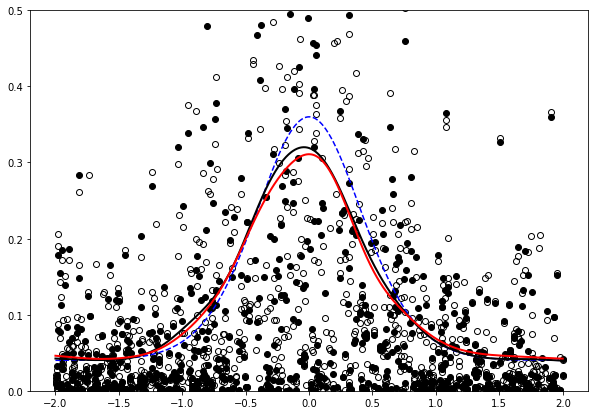

In [15]:
fig, ax = plt.subplots(1, 1,figsize=(10, 7))

plt.plot(df['x'],df['res'],'o',mfc='none',color='black')

plt.plot(df_cc['x'],df_cc['res'],'o',color='black')

#Truth
ax.plot(np.linspace(-2, 2, n),sigma_reg(np.linspace(-2, 2, n),n)**2, color='blue',markersize=3,linestyle='dashed')


#Full
ax.plot(np.linspace(-2, 2, n),model_res.fit(np.linspace(-2, 2, n))[0] ,color= 'black', lw=2)

#IPW
ax.plot(np.linspace(-2, 2, n),[sigma_mis_res(h_ipw_var,t,df_cc.x,df_cc.res,pi(df_cc.y,b0,b1),df_ones[0])**2 for t in np.linspace(-2, 2, n)],'-g',color= 'red', lw=2)

ax.set_ylim(0,0.5)

plt.savefig(f'figures/Residual_{a}_{size}.pdf',transparent=True)


In [16]:
ICE_full = [(sigma_reg(t,n)**2 - model_res.fit([t])[0][0])**2 for t in np.linspace(-2, 2, n)]
ICE_IPW = [(sigma_reg(t,n)**2 - sigma_mis_res(h_ipw_var,t,df_cc.x,df_cc.res,pi(df_cc.y,b0,b1),df_ones[0])**2)**2 for t in np.linspace(-2, 2, n)]

In [17]:
print('ICE FULL:' +str(np.trapz(ICE_full,x=np.linspace(-2, 2, n))))
print('ICE IPW IPW:' +str(np.trapz(ICE_IPW,x=np.linspace(-2, 2, n))))  

ICE FULL:0.001252578415777566
ICE IPW IPW:0.0017542677892149728


In [18]:
model_res.bw


array([0.20751485])

In [19]:
h_ipw_cc


array([0.08477096])

In [20]:
model.bw

array([0.0641201])

In [21]:
h_ipw_var

array([0.22131165])